# 02 — Feature Engineering (Spark-First, Big-Data Style)

Goal: build **Spark-native** features for price/demand-style modeling and pricing optimization.

Important caveat: this dataset is **cross-sectional** (no booking date / time index), so true seasonality/lag features are not present. Instead we engineer:
- Listing-level interaction features (price × satisfaction, price per person, etc.)
- Geo bucketing (grid cell) as a neighborhood proxy
- Competition indices computed from segment statistics (median price, competitor count)
- Segment-level aggregates for optimization (compact but derived from big-data transformations)

**Outputs**
- `data/processed/listing_features.parquet` (listing-level engineered features)
- `data/processed/segment_demand_dataset.parquet` (segment aggregates, used downstream)
- Optional small preview CSV in `outputs/` (bounded sample only)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
from pathlib import Path

# Locate project root (folder containing 'src')
project_root = Path.cwd()
for p in [project_root] + list(project_root.parents):
    if (p / 'src').exists():
        project_root = p
        break
if not (project_root / 'src').exists():
    raise FileNotFoundError("Could not find 'src' directory.")

# Windows Spark/Hadoop helpers (assumes hadoop binaries already exist from Notebook 01)
hadoop_home = project_root / 'hadoop'
bin_dir = hadoop_home / 'bin'
os.environ['HADOOP_HOME'] = str(hadoop_home)
os.environ['hadoop.home.dir'] = str(hadoop_home)
os.environ['PATH'] = str(bin_dir) + os.pathsep + os.environ.get('PATH', '')

sys.path.insert(0, str(project_root))

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = (
    SparkSession.builder
    .appName('airbnb-feature-engineering')
    .master('local[*]')
    .getOrCreate()
)

print('Spark version:', spark.version)

Spark version: 3.5.0


In [3]:
# Persist datasets (Spark writes)
out_processed = project_root / 'data' / 'processed'
out_processed.mkdir(parents=True, exist_ok=True)
outputs_dir = project_root / 'outputs'
outputs_dir.mkdir(parents=True, exist_ok=True)

In [4]:
from src.data_processing.feature_engineering import SparkFeatureEngineer

# Load raw parquet (no encoding yet)
df = spark.read.parquet(str(project_root / "data" / "processed" / "consolidated.parquet"))

print('Rows:', f"{df.count():,}")
print('Columns:', len(df.columns))
df.printSchema()

# Show a schema-aware sample (works for both old and new dataset schemas)
sample_cols = [c for c in ['city', 'weekend', 'day_type', 'room_type', 'listing_price', 'person_capacity', 'city_center_dist', 'metro_dist'] if c in df.columns]
df.select(*sample_cols).show(10, truncate=False)

Rows: 51,707
Columns: 16
root
 |-- listing_price: double (nullable = true)
 |-- room_type: string (nullable = true)
 |-- room_shared: integer (nullable = true)
 |-- room_private: integer (nullable = true)
 |-- person_capacity: double (nullable = true)
 |-- host_is_superhost: integer (nullable = true)
 |-- multi: integer (nullable = true)
 |-- biz: integer (nullable = true)
 |-- cleanliness_rating: double (nullable = true)
 |-- guest_satisfaction_overall: double (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- city_center_dist: double (nullable = true)
 |-- metro_dist: double (nullable = true)
 |-- city: string (nullable = true)
 |-- weekend: integer (nullable = true)
 |-- n_bookings: integer (nullable = true)

+---------+-------+---------------+------------------+---------------+------------------+------------------+
|city     |weekend|room_type      |listing_price     |person_capacity|city_center_dist  |metro_dist        |
+---------+-------+---------------+-------------

In [5]:
# Feature Engineering Spark pipeline: encode → engineer → segment

listing_features_df, segment_df = SparkFeatureEngineer.build_feature_dataset(
    df, 
    segment_cols=['city', 'weekend'],
    encode_categoricals=True
)

In [6]:
listing_features_df.columns

['listing_price',
 'room_shared',
 'room_private',
 'person_capacity',
 'host_is_superhost',
 'multi',
 'biz',
 'cleanliness_rating',
 'guest_satisfaction_overall',
 'bedrooms',
 'city_center_dist',
 'metro_dist',
 'n_bookings',
 'cat_room_type_entire_home_apt',
 'cat_room_type_private_room',
 'cat_room_type_shared_room',
 'cat_city_amsterdam',
 'cat_city_athens',
 'cat_city_barcelona',
 'cat_city_berlin',
 'cat_city_budapest',
 'cat_city_lisbon',
 'cat_city_london',
 'cat_city_paris',
 'cat_city_rome',
 'cat_city_vienna',
 'log_price',
 'price_per_person',
 'price_per_bedroom',
 'capacity_bin',
 'quality_score',
 'price_x_satisfaction',
 'price_per_dist_km',
 'log_metro_dist',
 'log_bookings',
 'is_weekend',
 'segment_listing_count',
 'segment_avg_price',
 'segment_median_price',
 'segment_p90_price',
 'segment_p10_price',
 'segment_price_std',
 'segment_price_spread',
 'price_vs_segment_median',
 'price_vs_segment_avg',
 'relative_price_volatility']

In [18]:
import json
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType

# Load elasticity dict
elasticity_path = project_root / 'outputs' / 'elasticities_by_segment.json'
if not elasticity_path.exists():
    raise FileNotFoundError(f'Missing {elasticity_path}. Run Notebook 01 elasticity analysis first.')

with open(elasticity_path, 'r') as f:
    elasticities_by_segment = json.load(f)

print(f"Loaded elasticity dict: {len(elasticities_by_segment)} segments")

# ============================================================================
# Convert elasticity dict to Spark DataFrame (DIRECTLY, no pandas)
# ============================================================================

# Define schema explicitly (avoids Python worker for type inference)
elasticity_schema = StructType([
    StructField("city", StringType(), False),
    StructField("weekend", IntegerType(), False),
    StructField("price_regime", StringType(), False),
    StructField("elasticity_slope", DoubleType(), False),
    StructField("breakpoint_log_price", DoubleType(), True)
])

# Flatten the elasticity dict into a list of tuples (not dicts)
elasticity_rows = []
for segment_key, segment_data in elasticities_by_segment.items():
    # Parse segment_key (e.g., "amsterdam_weekend" → city="amsterdam", weekend=1)
    parts = segment_key.rsplit('_', 1)
    city = parts[0]
    weekend = 1 if parts[1] == 'weekend' else 0
    
    breakpoint_log_price = segment_data.get('breakpoint_log_price')
    regimes = segment_data.get('regimes', [])
    
    if not regimes:
        continue
    
    # Single regime: one row
    if len(regimes) == 1:
        elasticity_rows.append((
            city,
            weekend,
            'all',
            float(regimes[0]['slope']),
            None
        ))
    
    # Two regimes: two rows (low/high price)
    elif len(regimes) > 1 and breakpoint_log_price is not None:
        elasticity_rows.append((
            city,
            weekend,
            'low',
            float(regimes[0]['slope']),
            float(breakpoint_log_price)
        ))
        elasticity_rows.append((
            city,
            weekend,
            'high',
            float(regimes[1]['slope']),
            float(breakpoint_log_price)
        ))

# Create Spark DataFrame WITHOUT spark.createDataFrame(list_of_rows)
# (that path uses PythonRDD → requires Python workers, which are failing on this machine)

elasticity_rows_path = outputs_dir / "elasticity_rows.jsonl"

with open(elasticity_rows_path, "w", encoding="utf-8") as f:
    for (city, weekend, price_regime, elasticity_slope, breakpoint_log_price) in elasticity_rows:
        f.write(json.dumps({
            "city": city,
            "weekend": int(weekend),
            "price_regime": price_regime,
            "elasticity_slope": float(elasticity_slope),
            "breakpoint_log_price": None if breakpoint_log_price is None else float(breakpoint_log_price),
        }) + "\n")

# JVM reader path (no Python workers)
elasticity_df = spark.read.schema(elasticity_schema).json(str(elasticity_rows_path))

print(f"✓ Created elasticity Spark DataFrame: {len(elasticity_rows)} rows (source file: {elasticity_rows_path.name})")
elasticity_df.show(10, truncate=False)

# ============================================================================
# Add 'city' and 'weekend' columns to listing_features_df (reverse one-hot encoding)
# ============================================================================

# Reverse one-hot encoding: create 'city' column from cat_city_* columns
city_cols = [c for c in listing_features_df.columns if c.startswith('cat_city_')]
city_case_expr = F.coalesce(
    *[F.when(F.col(col) == 1.0, F.lit(col.replace('cat_city_', ''))).otherwise(None) for col in city_cols]
)

listing_features_df = listing_features_df.withColumn('city', city_case_expr)

# 'weekend' column: convert is_weekend (0.0/1.0) to integer
listing_features_df = listing_features_df.withColumn('weekend', F.col('is_weekend').cast('int'))

print("✓ Added 'city' and 'weekend' columns for join")

# ============================================================================
# Join elasticity slopes (Spark SQL, no UDF)
# ============================================================================

# For single-regime segments: direct join
single_regime_df = elasticity_df.filter(F.col('price_regime') == 'all')

listing_features_df = (
    listing_features_df
    .join(
        single_regime_df.select('city', 'weekend', F.col('elasticity_slope').alias('elasticity_single')),
        on=['city', 'weekend'],
        how='left'
    )
)

# For two-regime segments: conditional join based on log_price < breakpoint
two_regime_low = elasticity_df.filter(F.col('price_regime') == 'low')
two_regime_high = elasticity_df.filter(F.col('price_regime') == 'high')

listing_features_df = (
    listing_features_df
    .join(
        two_regime_low.select(
            'city', 'weekend',
            F.col('elasticity_slope').alias('elasticity_low'),
            F.col('breakpoint_log_price').alias('breakpoint')
        ),
        on=['city', 'weekend'],
        how='left'
    )
    .join(
        two_regime_high.select('city', 'weekend', F.col('elasticity_slope').alias('elasticity_high')),
        on=['city', 'weekend'],
        how='left'
    )
)

# Select appropriate elasticity based on price regime
listing_features_df = listing_features_df.withColumn(
    'elasticity_slope',
    F.coalesce(
        # Single regime (use if elasticity_single is not null)
        F.col('elasticity_single'),
        # Two-regime: use low/high based on price threshold
        F.when(F.col('log_price') < F.col('breakpoint'), F.col('elasticity_low')).otherwise(F.col('elasticity_high'))
    )
)

# Drop temporary columns
listing_features_df = listing_features_df.drop('elasticity_single', 'elasticity_low', 'elasticity_high', 'breakpoint')

print("✓ Elasticity slopes joined (pure Spark SQL)")

# ============================================================================
# Fill NaN by (city, weekend) segment mean (smart imputation)
# ============================================================================

# Compute segment-level elasticity mean (only for listings with non-null values)
segment_elasticity_stats = (
    listing_features_df
    .where(F.col('elasticity_slope').isNotNull())
    .groupBy('city', 'weekend')
    .agg(F.avg('elasticity_slope').alias('segment_elasticity_mean'))
)

# Join back and fill NaN with segment-level mean
listing_features_df = (
    listing_features_df
    .join(segment_elasticity_stats, on=['city', 'weekend'], how='left')
    .withColumn(
        'elasticity_slope',
        F.coalesce(F.col('elasticity_slope'), F.col('segment_elasticity_mean'))
    )
    .drop('segment_elasticity_mean')
)

print("✓ Missing elasticity values filled by (city, weekend) segment mean")

# ============================================================================
# Statistics (Pure Spark, no Python workers)
# ============================================================================

stats_df = listing_features_df.agg(
    F.count('elasticity_slope').alias('total_listings'),
    F.sum(F.col('elasticity_slope').isNull().cast('int')).alias('null_count'),
    F.countDistinct(F.col('elasticity_slope')).alias('unique_slopes'),
    F.avg('elasticity_slope').alias('mean_slope'),
    F.stddev('elasticity_slope').alias('std_slope'),
    F.min('elasticity_slope').alias('min_slope'),
    F.max('elasticity_slope').alias('max_slope'),
)

print("\n" + "="*70)
print("Elasticity Slope Statistics (Spark Aggregations)")
print("="*70)
stats_df.show(truncate=False)

# Show per-segment breakdown (small table - safe toPandas on ~20 rows)
print("\nElasticity by Segment (city × weekend):")
segment_breakdown = (
    listing_features_df
    .groupBy('city', 'weekend')
    .agg(
        F.count('*').alias('listing_count'),
        F.avg('elasticity_slope').alias('avg_elasticity'),
        F.min('elasticity_slope').alias('min_elasticity'),
        F.max('elasticity_slope').alias('max_elasticity'),
    )
    .orderBy('city', 'weekend')
    .toPandas()  # ✅ Safe: only ~20 rows
)

print(segment_breakdown.to_string(index=False))

Loaded elasticity dict: 20 segments
✓ Created elasticity Spark DataFrame: 35 rows (source file: elasticity_rows.jsonl)
+---------+-------+------------+--------------------+--------------------+
|city     |weekend|price_regime|elasticity_slope    |breakpoint_log_price|
+---------+-------+------------+--------------------+--------------------+
|amsterdam|0      |low         |-0.21681263698945502|5.63994743678348    |
|amsterdam|0      |high        |-0.6587899731091714 |5.63994743678348    |
|amsterdam|1      |low         |-0.21374376405111942|5.778504378466375   |
|amsterdam|1      |high        |-0.688012798321685  |5.778504378466375   |
|athens   |0      |low         |-0.03010176397345103|4.745827814110222   |
|athens   |0      |high        |-0.36150756784280824|4.745827814110222   |
|athens   |1      |low         |0.07695053742625325 |4.646472127984398   |
|athens   |1      |high        |-0.3851920145047737 |4.646472127984398   |
|barcelona|0      |low         |-0.21032817015150684|5.2

In [19]:
# Save Spark outputs (native format, no toPandas)
listing_features_df.write.mode('overwrite').parquet(str(out_processed / 'listing_features.parquet'))
segment_df.write.mode('overwrite').parquet(str(out_processed / 'segment_demand_dataset.parquet'))

# Safe small preview only
preview_pdf = segment_df.limit(2000).toPandas()
preview_pdf.to_csv(outputs_dir / 'segment_dataset_preview.csv', index=False)

In [20]:
# Pretty-print engineered features via a styled Pandas DataFrame (safe limit + formatting)
features_pdf = listing_features_df.limit(5000).toPandas().head(10)

# Format dictionary for display
fmt_features = {
    "listing_price": "{:,.2f}",
    "bedrooms": "{:.1f}",
    "city_center_dist": "{:,.2f}",
    "metro_dist": "{:,.2f}",
    "n_bookings": "{:,.0f}",
    "price_per_bedroom": "{:,.2f}",
    "quality_score": "{:.2f}",
    "price_x_satisfaction": "{:,.2f}",
    "price_per_dist_km": "{:,.2f}",
    "segment_listing_count": "{:,.0f}",
    "segment_avg_price": "{:,.2f}",
    "segment_median_price": "{:,.2f}",
    "segment_p90_price": "{:,.2f}",
    "segment_p10_price": "{:,.2f}",
    "segment_price_std": "{:,.2f}",
    "segment_price_spread": "{:,.2f}",
    "price_vs_segment_median": "{:.3f}",
    "price_vs_segment_avg": "{:.3f}",
    "relative_price_volatility": "{:.3f}",
}

display(
    features_pdf.style.format(fmt_features)
                      .set_table_attributes("style='width:95%; font-family: Arial; font-size:11px;'")
                      .set_caption("Engineered listing features (Spark → Pandas, sample)")
)

,city,weekend,cat_city_amsterdam,cat_city_athens,cat_city_barcelona,cat_city_berlin,cat_city_budapest,cat_city_lisbon,cat_city_london,cat_city_paris,cat_city_rome,cat_city_vienna,is_weekend,listing_price,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,city_center_dist,metro_dist,n_bookings,cat_room_type_entire_home_apt,cat_room_type_private_room,cat_room_type_shared_room,log_price,price_per_person,price_per_bedroom,capacity_bin,quality_score,price_x_satisfaction,price_per_dist_km,log_metro_dist,log_bookings,segment_listing_count,segment_avg_price,segment_median_price,segment_p90_price,segment_p10_price,segment_price_std,segment_price_spread,price_vs_segment_median,price_vs_segment_avg,relative_price_volatility,elasticity_slope
0,amsterdam,0,1,0,0,0,0,0,0,0,0,0,0,194.03,0,1,2.000000,0,1,0,10.000000,93.000000,1.0,5.02,2.54,21,0,1,0,5.273172,97.016849,194.03,2,49.50,180.45,37.88,1.263952,3.091042,"1,103",545.02,430.25,950.02,245.59,416.97,704.43,0.451,0.356,1.637,-0.216813
1,amsterdam,0,1,0,0,0,0,0,0,0,0,0,0,344.25,0,1,4.000000,0,0,0,8.000000,85.000000,1.0,0.49,0.24,11,0,1,0,5.844257,86.061444,344.25,4,62.95,292.61,585.06,0.214631,2.484907,"1,103",545.02,430.25,950.02,245.59,416.97,704.43,0.800,0.632,1.637,-0.658790
2,amsterdam,0,1,0,0,0,0,0,0,0,0,0,0,264.10,0,1,2.000000,0,0,1,9.000000,87.000000,1.0,5.75,3.65,8,0,1,0,5.580112,132.050711,264.10,2,46.20,229.77,45.16,1.537216,2.197225,"1,103",545.02,430.25,950.02,245.59,416.97,704.43,0.614,0.485,1.637,-0.216813
3,amsterdam,0,1,0,0,0,0,0,0,0,0,0,0,433.53,0,1,4.000000,0,0,1,9.000000,90.000000,2.0,0.38,0.44,12,0,1,0,6.074264,108.382349,216.76,4,66.16,390.18,894.13,0.364557,2.564949,"1,103",545.02,430.25,950.02,245.59,416.97,704.43,1.008,0.795,1.637,-0.658790
4,amsterdam,0,1,0,0,0,0,0,0,0,0,0,0,485.55,0,1,2.000000,1,0,0,10.000000,98.000000,1.0,0.54,0.32,15,0,1,0,6.187346,242.776463,485.55,2,69.82,475.84,753.10,0.276641,2.772589,"1,103",545.02,430.25,950.02,245.59,416.97,704.43,1.129,0.891,1.637,-0.658790
5,amsterdam,0,1,0,0,0,0,0,0,0,0,0,0,552.81,0,1,3.000000,0,0,0,8.000000,100.000000,2.0,2.13,1.90,10,0,1,0,6.316819,184.269522,276.40,3,63.87,552.81,247.74,1.066319,2.397895,"1,103",545.02,430.25,950.02,245.59,416.97,704.43,1.285,1.014,1.637,-0.658790
6,amsterdam,0,1,0,0,0,0,0,0,0,0,0,0,215.12,0,1,2.000000,0,0,0,10.000000,94.000000,1.0,1.88,0.73,12,0,1,0,5.375854,107.562159,215.12,2,62.48,202.22,108.59,0.547975,2.564949,"1,103",545.02,430.25,950.02,245.59,416.97,704.43,0.500,0.395,1.637,-0.216813
7,amsterdam,0,1,0,0,0,0,0,0,0,0,0,0,"2,771.31",0,0,4.000000,1,0,0,10.000000,100.000000,3.0,1.69,1.46,4,1,0,0,7.927435,692.826846,923.77,4,66.25,"2,771.31","1,550.98",0.899512,1.609438,"1,103",545.02,430.25,950.02,245.59,416.97,704.43,6.441,5.085,1.637,-0.658790
8,amsterdam,0,1,0,0,0,0,0,0,0,0,0,0,"1,001.80",0,0,4.000000,0,0,0,9.000000,96.000000,2.0,3.72,1.20,5,1,0,0,6.910556,250.451105,500.90,4,55.82,961.73,262.31,0.786689,1.791759,"1,103",545.02,430.25,950.02,245.59,416.97,704.43,2.328,1.838,1.637,-0.658790
9,amsterdam,0,1,0,0,0,0,0,0,0,0,0,0,276.52,0,1,2.000000,0,1,0,10.000000,88.000000,1.0,3.14,0.92,14,0,1,0,5.625898,138.260727,276.52,2,54.43,243.34,85.28,0.654617,2.708050,"1,103",545.02,430.25,950.02,245.59,416.97,704.43,0.643,0.507,1.637,-0.216813


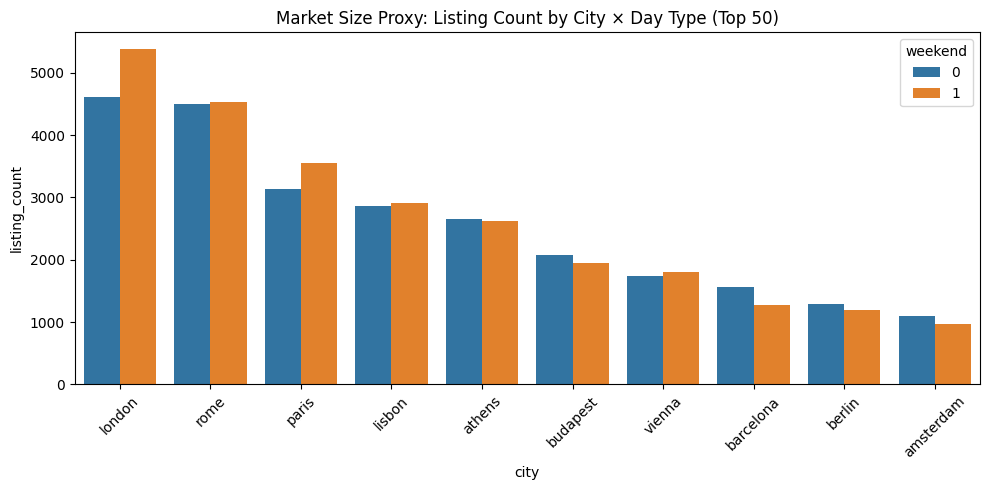

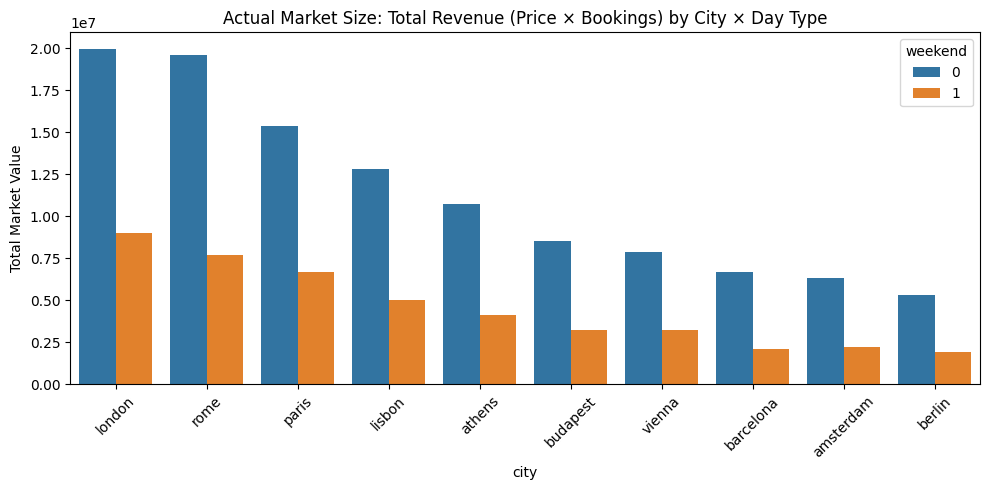

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate to a small table first (Spark)
city_day = (
    segment_df.groupBy('city', 'weekend')
    .agg(F.sum('listing_count').alias('listing_count'))
    .orderBy(F.desc('listing_count'))
    .limit(50)
    .toPandas()
)

plt.figure(figsize=(10, 5))
sns.barplot(data=city_day, x='city', y='listing_count', hue='weekend')
plt.title('Market Size Proxy: Listing Count by City × Day Type (Top 50)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(project_root / 'outputs' / 'listing_count_by_city_daytype.png', dpi=150)
plt.show()

# Calculate actual market size (price × bookings) in Spark using the raw df (has 'city' and 'weekend')
market_size = (
    df.groupBy('city', 'weekend')
    .agg(
        F.sum(F.col('listing_price') * F.col('n_bookings')).alias('total_market_value'),
        F.count('*').alias('listing_count'),
        F.avg('listing_price').alias('avg_price')
    )
    .orderBy(F.desc('total_market_value'))
    .limit(50)
    .toPandas()
)

plt.figure(figsize=(10, 5))
sns.barplot(data=market_size, x='city', y='total_market_value', hue='weekend')
plt.title('Actual Market Size: Total Revenue (Price × Bookings) by City × Day Type')
plt.ylabel('Total Market Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(project_root / 'outputs' / 'market_size_by_city_daytype.png', dpi=150)
plt.show()